## 0. Import Libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load Data

In [2]:
def load_dataset_and_labels(base_dir, target_frames=100, stride=None):
    """
    Load dataset with sliding windows

    Args:
        base_dir (str): 데이터셋 디렉토리 경로.
        target_frames (int): 슬라이싱할 프레임 수.
        stride (int): 슬라이딩 윈도우 이동 간격. None이면 target_frames 사용.

    Returns:
        np.ndarray: X 데이터 (슬라이싱된 샘플).
        np.ndarray: y 데이터 (레이블).
    """
    X = []
    y = []
    stride = stride if stride is not None else target_frames  # 기본 이동 간격은 target_frames

    for label in os.listdir(base_dir):
        class_path = os.path.join(base_dir, label)
        if not os.path.isdir(class_path):
            continue
            
        # 디렉토리 이름에서 맨 앞 숫자로 label 설정
        label_number = int(label.split("-")[0])
        for file in os.listdir(class_path):
            if file.endswith(".npy"):
                file_path = os.path.join(class_path, file)
                data = np.load(file_path)
                total_frames = data.shape[0]

                # 데이터를 target_frames 단위로 슬라이싱 (슬라이딩 윈도우)
                for start in range(0, total_frames - target_frames + 1, stride):
                    chunk = data[start:start + target_frames]
                    X.append(chunk)
                    y.append(label_number)

    return np.array(X), np.array(y)

In [3]:
base_dir = "/kaggle/input/combfeatures"
target_frames = 100
stride = 80
X, y = load_dataset_and_labels(base_dir, target_frames=target_frames, stride=stride)

In [4]:
X.shape # (batch, frames, 120, 25) 
# 120: 사람 3명의 관절 30개 + 위치관계 30 & 25: 비디오 (x,y,z) expend 4 + 오디오 13

(3935, 100, 120, 25)

In [5]:
# Train data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# 전체 클래스 비율
unique_classes, total_counts = np.unique(y, return_counts=True)
total_samples = len(y)
print("\nOverall Class Distribution:")
for cls, count in zip(unique_classes, total_counts):
    print(f"Class {cls}: {count} ({count / total_samples:.2%})")

# 훈련 데이터 클래스 비율
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_samples = len(y_train)
print("\nTrain Class Distribution:")
for cls, count in zip(train_classes, train_counts):
    print(f"Class {cls}: {count} ({count / train_samples:.2%})")

# 테스트 데이터 클래스 비율
test_classes, test_counts = np.unique(y_test, return_counts=True)
test_samples = len(y_test)
print("\nTest Class Distribution:")
for cls, count in zip(test_classes, test_counts):
    print(f"Class {cls}: {count} ({count / test_samples:.2%})")


Overall Class Distribution:
Class 0: 2189 (55.63%)
Class 1: 990 (25.16%)
Class 2: 756 (19.21%)

Train Class Distribution:
Class 0: 1751 (55.62%)
Class 1: 792 (25.16%)
Class 2: 605 (19.22%)

Test Class Distribution:
Class 0: 438 (55.65%)
Class 1: 198 (25.16%)
Class 2: 151 (19.19%)


## 2. Model Definition

In [7]:
@register_keras_serializable(package="Custom", name="PositionalEncoding")
class PositionalEncoding(Layer):
    """
    Positional Encoding layer:
    - 입력 데이터에 sequence 내 위치 정보를 추가합니다.
    - Transformer 모델에서 순서 정보가 없는 입력 데이터에 위치 정보를 부여하기 위해 사용됩니다.
    """
    def call(self, inputs):
        """
        Args:
            inputs: (batch_size, sequence_length, features) 형태의 Tensor.
            
        Returns:
            Positional Encoding이 추가된 Tensor.
        """
        seq_len = tf.shape(inputs)[1]  # sequence length
        d_model = tf.cast(tf.shape(inputs)[2], tf.float32)  # Features (float32로 변환)

        # 위치 인덱스 생성
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))  # TensorFlow 연산 사용

        # 위치 인코딩 계산
        # Sine은 짝수 인덱스, Cosine은 홀수 인덱스에서 사용
        positional_encoding = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)
        positional_encoding = tf.expand_dims(positional_encoding, 0)  # 배치 차원 추가

        # Scaling factor(Optional)): positional encoding 값의 크기를 조정
        scale_factor = 0.1
        return inputs + positional_encoding * scale_factor

In [8]:
@register_keras_serializable(package="Custom", name="AttentionPooling1D")
class AttentionPooling1D(Layer):
    """
    Attention based Pooling layer.

    이 레이어는 input sequence의 각 time step에 대해 중요도 점수를 계산하고,
    해당 점수를 기반으로 전체 sequence를 하나의 벡터로 요약합니다.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 입력의 각 time step에 대해 중요도 점수를 계산하기 위한 Dense 레이어 (출력 차원: 1)
        self.query = Dense(1)

    def call(self, inputs):
        """
        Args:
            inputs (Tensor) shape: (batch_size, time_steps, features)

        Returns:
            Tensor: (batch_size, features)
                    입력 sequence의 중요도를 반영하여 요약된 벡터를 반환합니다.
        """
        # 입력 데이터의 각 타임스텝에 대해 중요도 점수 계산하고 softmax 적용.
        scores = tf.nn.softmax(self.query(inputs), axis=1)
        
        # 각 타임스텝의 값을 중요도 점수와 곱하여 가중합 계산
        return tf.reduce_sum(scores * inputs, axis=1)

In [9]:
def split_data(X):
    """
    Reshape (n, 100, 120, 25) into four parts of (n, 100, 750) each
    for memory and computational efficiency.
    """
    # 120 기준으로 4등분
    split1 = X[:, :, :30, :]  # 첫 번째 30 sequence - person 1
    split2 = X[:, :, 30:60, :]  # person 2
    split3 = X[:, :, 60:90, :]  # person 3
    split4 = X[:, :, 90:, :]  # 위치 관계

    split1 = split1.reshape(X.shape[0], X.shape[1], -1)
    split2 = split2.reshape(X.shape[0], X.shape[1], -1)
    split3 = split3.reshape(X.shape[0], X.shape[1], -1)
    split4 = split4.reshape(X.shape[0], X.shape[1], -1)

    return split1, split2, split3, split4

In [10]:
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    """
    Args:
        inputs (Tensor): (batch_size, sequence_length, features).
        head_size (int): 각 Attention Head의 차원 크기.
        num_heads (int): Attention Head의 개수.
        ff_dim (int): Feed Forward Network의 차원 크기.
        dropout (float): 과적합 방지를 위한 Dropout 비율.

    Returns:
        Tensor: 입력과 동일한 shape의 출력 텐서 (batch_size, sequence_length, features).
    """
    # Multi-Head Self Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)  # Residual Connection

    # Feed Forward Network
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(ff + attention)  # Residual Connection

    return ff

In [11]:
def build_split_transformer_model(input_shape, num_classes, num_transformer_blocks=2, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    """
    Transformer based model with split input:
    - 입력 데이터를 네 부분으로 나누어 Transformer Blocks로 개별 처리.

    Args:
        input_shape (tuple): 각 분할 입력의 shape (sequence_length, features).
        num_classes (int): 분류해야 할 클래스 개수.
        num_transformer_blocks (int): 각 분할에 적용할 Transformer Block의 개수.
        head_size (int): 각 Attention Head의 크기.
        num_heads (int): Attention Head의 개수.
        ff_dim (int): Feed Forward Network의 차원 크기.
        dropout (float): Dropout 비율.

    Returns:
        Model: Keras 모델 인스턴스.
    """
    positional_encoding = PositionalEncoding()
    
    # Input Layer
    input1 = Input(shape=(input_shape[0], input_shape[1]))
    input2 = Input(shape=(input_shape[0], input_shape[1]))
    input3 = Input(shape=(input_shape[0], input_shape[1]))
    input4 = Input(shape=(input_shape[0], input_shape[1]))
    
    # Apply Positional Encoding and Transformer Blocks to each split input
    def process_split(input_layer):
        x = positional_encoding(input_layer)
        for _ in range(num_transformer_blocks):
            x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
        return x

    processed1 = process_split(input1)
    processed2 = process_split(input2)
    processed3 = process_split(input3)
    processed4 = process_split(input4)

    # Merge the processed splits
    x = Concatenate(axis=-1)([processed1, processed2, processed3, processed4])  # Shape: (n, 100, 3000)

    # AttentionPooling1D for summarizing sequence information
    x = AttentionPooling1D()(x) # Shape: (n, 3000)
    x = Dropout(0.2)(x)

    # Fully Connected Layers
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Compile Model
    model = Model(inputs=[input1, input2, input3, input4], outputs=outputs)
    model.compile(
        optimizer="nadam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

## 3. Build Model

In [12]:
# Prepare Data
X_train1, X_train2, X_train3, X_train4 = split_data(X_train)
X_test1, X_test2, X_test3, X_test4 = split_data(X_test)

# Build and Train Model
input_shape = (X_train1.shape[1], X_train1.shape[2])  # (100, 750)
num_classes = len(np.unique(y_train))

model = build_split_transformer_model(input_shape, num_classes)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 750)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100, 750)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100, 750)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 100, 750)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 100, 750)  │          0 │ input_layer[0][0… │
│ (PositionalEncodin… │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 750)  │    769,518 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 750)  │    769,518 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 750)  │    769,518 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 750)  │    769,518 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 750)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100, 750)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 100, 750)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 100, 750)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 750)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 750)  │          0 │ dropout_7[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 100, 750)  │          0 │ dropout_13[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 100, 750)  │          0 │ dropout_19[0][0]

 Total params: 7,918,428 (30.21 MB)

 Trainable params: 7,918,428 (30.21 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Data Augmentation for Batch

In [14]:
class AugmentedSplitDataGenerator:
    """
    Custom Data Generator Class for data augmentation for each batch
    
    Args:
        X_splits (list of numpy.ndarray): 분할된 입력 data list.
        y (numpy.ndarray): target label.
        batch_size (int): 배치 크기.
        augment_ratio (float): Class 1, 2 데이터의 증강 비율.
        noise_level (float): 증강 시 추가할 노이즈의 강도.
    """
    def __init__(self, X_splits, y, batch_size, augment_ratio=0.1, noise_level=0.01):
        self.X_splits = X_splits
        self.y = y
        self.batch_size = batch_size
        self.augment_ratio = augment_ratio
        self.noise_level = noise_level
        self.indices = np.arange(len(y)) # 전체 data index

    def __len__(self):
        """
        전체 데이터셋을 배치 크기로 나눈 총 배치 개수 반환.
        """
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        """
        특정 배치의 데이터를 반환.
        
        Args:
            idx (int): 요청된 배치 인덱스.
        
        Returns:
            tuple: (분할된 입력 데이터의 배치, 배치 레이블).
        """
        # 현재 배치에 포함될 데이터 인덱스 계산
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        # 각 분할된 입력 데이터에서 배치 추출
        X_batch_splits = [X[batch_indices] for X in self.X_splits]
        y_batch = self.y[batch_indices]

        # 클래스 1과 2 데이터 증강
        class1_indices = np.where(y_batch == 1)[0]
        class2_indices = np.where(y_batch == 2)[0]

        class1_sample_size = int(len(class1_indices) * self.augment_ratio)
        class2_sample_size = int(len(class2_indices) * self.augment_ratio)

        if class1_sample_size > 0:
            sampled_class1_indices = class1_indices[:class1_sample_size]
            for i in range(len(X_batch_splits)):
                augmented_class1 = self.augment_data(X_batch_splits[i][sampled_class1_indices])
                X_batch_splits[i] = np.vstack((X_batch_splits[i], augmented_class1))
            y_batch = np.hstack((y_batch, [1] * class1_sample_size))

        if class2_sample_size > 0:
            sampled_class2_indices = class2_indices[:class2_sample_size]
            for i in range(len(X_batch_splits)):
                augmented_class2 = self.augment_data(X_batch_splits[i][sampled_class2_indices])
                X_batch_splits[i] = np.vstack((X_batch_splits[i], augmented_class2))
            y_batch = np.hstack((y_batch, [2] * class2_sample_size))

        return tuple(X_batch_splits), y_batch

    def augment_data(self, data):
        """
        노이즈 추가로 데이터 증강
        Args:
            data (numpy.ndarray): 원본 데이터.
        
        Returns:
            numpy.ndarray: 노이즈가 추가된 증강 데이터.
        """
        noise = np.random.normal(0, self.noise_level, data.shape)
        return data + noise

In [15]:
def create_dataset(generator, output_signature):
    """
    데이터 생성기를 tf.data.Dataset로 변환.

    Args:
        generator (function): 데이터 생성 함수.
        output_signature (tuple): 출력 형식 정의.

    Returns:
        tf.data.Dataset: 변환된 데이터셋.
    """
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

In [16]:
# Generator 함수 정의
def train_generator():
    for idx in range(len(train_generator_instance)):
        yield train_generator_instance[idx]

# Output Signature 정의
output_signature = (
    (
        tf.TensorSpec(shape=(None, X_train1.shape[1], X_train1.shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train2.shape[1], X_train2.shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train3.shape[1], X_train3.shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train4.shape[1], X_train4.shape[2]), dtype=tf.float32),
),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

In [17]:
batch_size = 64
augment_ratio = 0.3  # 클래스 1과 2의 일부만 증강
noise_level = 0.01

train_generator_instance = AugmentedSplitDataGenerator(
    [X_train1, X_train2, X_train3, X_train4], y_train, batch_size, augment_ratio, noise_level
)
train_dataset = create_dataset(train_generator, output_signature)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        (X_test1, X_test2, X_test3, X_test4),
        y_test
    )
).batch(batch_size)

## 5. Training

In [18]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=15,          # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the best weights after stopping
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


I0000 00:00:1733659277.777546      65 service.cc:145] XLA service 0x7d52fc00cd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733659277.777610      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      1/Unknown 86s 86s/step - accuracy: 0.3378 - loss: 1.3275

I0000 00:00:1733659339.486910      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     50/Unknown 456s 8s/step - accuracy: 0.6821 - loss: 1.3078

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 463s 8s/step - accuracy: 0.6846 - loss: 1.2952 - val_accuracy: 0.9720 - val_loss: 0.1107
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.9625 - loss: 0.1059 - val_accuracy: 0.9733 - val_loss: 0.0885
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.9773 - loss: 0.0728 - val_accuracy: 0.9771 - val_loss: 0.0852
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9806 - loss: 0.0558 - val_accuracy: 0.9314 - val_loss: 0.3897
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9760 - loss: 0.0920 - val_accuracy: 0.9797 - val_loss: 0.0647
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.9786 - loss: 0.0598 - val_accuracy: 0.7802 - val_loss: 0.5406
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.9533 - loss: 0.1298 - val_accuracy: 0.5222 - val_loss: 2.4057
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.8841 - loss: 0.3851 - val_accuracy: 

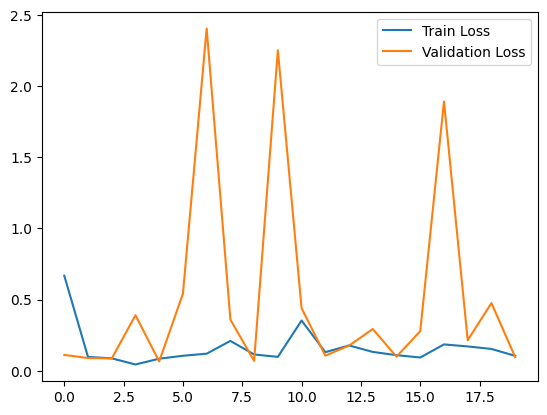

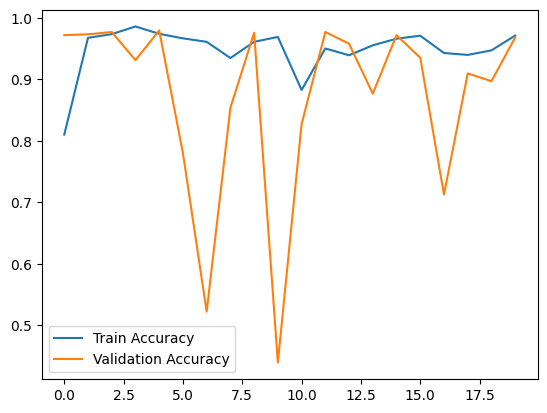

In [19]:
# Loss 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# ACC 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

## 6. Prediction and Confusion Matrix

In [20]:
# 테스트 데이터 예측
y_pred = np.argmax(model.predict([X_test1, X_test2, X_test3, X_test4]), axis=1)

# 확인: y_test와 y_pred가 1차원 배열인지
print("Shapes - y_test:", y_test.shape, "y_pred:", y_pred.shape)

# 1. 정확도 (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 2. 정밀도, 재현율, F1 점수 (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# 3. 혼동 행렬 (Confusion Matrix)
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
Shapes - y_test: (787,) y_pred: (787,)
Test Accuracy: 0.9797

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       438
     Class 1       0.94      0.98      0.96       198
     Class 2       0.98      0.94      0.96       151

    accuracy                           0.98       787
   macro avg       0.97      0.97      0.97       787
weighted avg       0.98      0.98      0.98       787


Confusion Matrix:
[[434   3   1]
 [  1 195   2]
 [  0   9 142]]


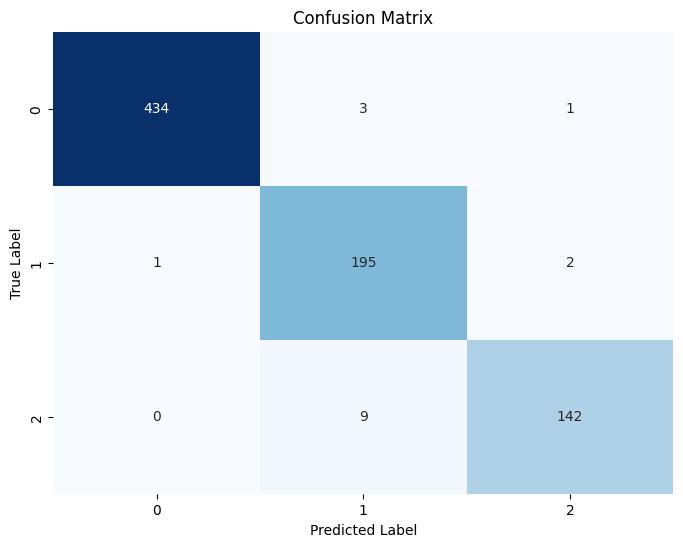

In [21]:
# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 7. Model Saving

In [22]:
import json
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login, HfApi
from huggingface_hub import hf_hub_download
from tensorflow.keras.models import load_model

In [23]:
MODEL_PATH="silver_assistant_transformer.keras"

In [24]:
# 모델 저장
model.save(MODEL_PATH)

In [25]:
custom_objects = {"PositionalEncoding": "PositionalEncoding"}

config = {
    "input_shape": model.input_shape,
    "output_shape": model.output_shape,
    "num_layers": len(model.layers),
    "custom_objects": {  # 사용자 정의 객체
        "PositionalEncoding": "PositionalEncoding",
        "AttentionPooling1D": "AttentionPooling1D"
    },
}

# config.json 저장
with open("config.json", "w") as f:
    json.dump(config, f)

In [26]:
user_secrets = UserSecretsClient()
HF = user_secrets.get_secret("HF_WRITE")
login(token=HF)
api = HfApi()
api = HfApi()

# 모델 파일 업로드
api.upload_file(
    path_or_fileobj=MODEL_PATH,
    path_in_repo=MODEL_PATH,
    repo_id="yunzi7/silverAssistant",
    repo_type="model"
)

# config.json 업로드
api.upload_file(
    path_or_fileobj="config.json",
    path_in_repo="config.json",
    repo_id="yunzi7/silverAssistant",
    repo_type="model"
)

silver_assistant_transformer.keras:   0%|          | 0.00/95.4M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/yunzi7/silverAssistant/commit/1542d7d23694f8da2b72474a977abe1746afcb0f', commit_message='Upload config.json with huggingface_hub', commit_description='', oid='1542d7d23694f8da2b72474a977abe1746afcb0f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yunzi7/silverAssistant', endpoint='https://huggingface.co', repo_type='model', repo_id='yunzi7/silverAssistant'), pr_revision=None, pr_num=None)

## 8. Loda Model for Inference

In [27]:
# Hugging Face Hub에서 모델 다운로드
model_path = hf_hub_download(repo_id="yunzi7/silverAssistant", filename=MODEL_PATH)

# 사용자 정의 클래스 로드
model = load_model(
    model_path,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "AttentionPooling1D": AttentionPooling1D
    }
)

print("모델 로드 성공")

silver_assistant_transformer.keras:   0%|          | 0.00/95.4M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'attention_pooling1d', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


모델 로드 성공


In [28]:
y_pred = np.argmax(model.predict([X_test1, X_test2, X_test3, X_test4]), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step
Test Accuracy: 0.9797
